To-Do List:
- Preprocessing: Tokenization, Lemmatization, Stopword removal
- Represent the Text: TF-IDF, Word2Vec or Bert
- Models: SVM or LSTM
- Evaluation: Precision, Recall, F1

In [ ]:
# Do we need this?
# pip install requests

# SENTIMENT ANALYSIS TASK ON ROTTEN TOMATOES DATABASE

## Exploratory Data Analysis

Firstly, we import the movie review dataset and the necessary libraries.

In [ ]:
import pandas as pd
import re

In [ ]:
splits = {'train': 'train.parquet', 'validation': 'validation.parquet', 'test': 'test.parquet'}
df = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["train"])
validation_df = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["validation"])
test_df = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["test"])

We visualize the first 10 entries in our dataset.

In [ ]:
df.head(10)

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
5,the film provides some great insight into the ...,1
6,offers that rare combination of entertainment ...,1
7,perhaps no picture ever made has more literall...,1
8,steers turns in a snappy screenplay that curls...,1
9,take care of my cat offers a refreshingly diff...,1


We can see that the dataset is composed of reviews and the labels of these reviews. Positive reviews are labelled 1 and negative reviews are labelled 0.

In [ ]:
df.shape

(8530, 2)

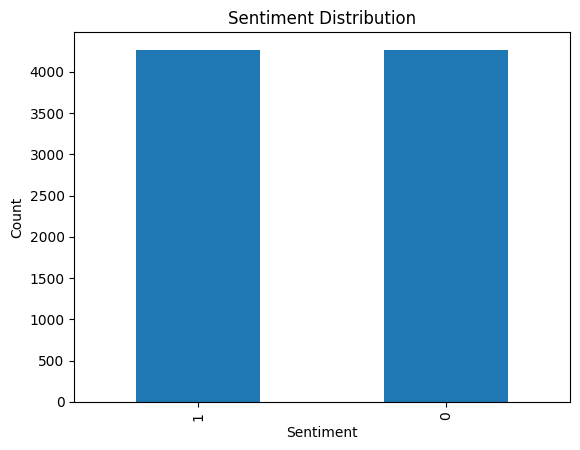

In [ ]:
label_counts = df.label.value_counts()

import matplotlib.pyplot as plt
plt.figure()
label_counts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


It can be seen that we have a balanced distribution in our labels.

## Preprocessing

As for the preprocessing, first of all we need to put the all the words in lowercase and then tokenize them

## Neural networks approach

Put to lowercase
Tokenize
Embeddings from GloVe or Word2Vec
Build the network

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import decoders
from tokenizers.normalizers import Lowercase


tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.normalizer = Lowercase()
tokenizer.pre_tokenizer = Whitespace()

trainer = WordLevelTrainer(
    vocab_size=25000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
)
tokenizer.train_from_iterator(iterator=df['text'], trainer=trainer)
tokenizer.save("tokenizer.json")

In [ ]:
tokenizer.encode("a Test sentence").tokens

['a', 'test', 'sentence']

I will get the embeddings from Glove model to use them in my rnn since i used the wordLevel tokenizer

In [ ]:
import os
os.path.exists("glove_data/glove.6B.100d.txt")

False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
glove_path = "/content/drive/MyDrive/glove.6B.100d.txt"
if not os.path.exists("/content/drive/MyDrive/glove.6B.100d.txt"):
    print("Downloading GloVe...")
    import requests, zipfile, io
    glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
    response = requests.get(glove_url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall("glove_data")  # Extract once
    os.rename("glove_data/glove.6B.100d.txt", glove_path)  # Move to working dir
    print("Download complete!")
else:
    print("Loading from local file...")

# Load embeddings (works for both first and subsequent runs)
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        embeddings_index[word] = np.array(vector, dtype=np.float32)

print(f"Loaded {len(embeddings_index)} word vectors.")

Loading from local file...
Loaded 400000 word vectors.


In [ ]:
vocab = tokenizer.get_vocab()
vocab_size = len(vocab) + 1 #for padding token
print("Vocabulary size:", vocab_size)
embedding_dim = 100

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: index for index, word in vocab.items()}


Vocabulary size: 16551


In [ ]:

#for i, word in word_index.items():
#    if word in embeddings_index:
#        embedding_matrix[i] = embeddings_index[word]

for i, word in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word.lower())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (16551, 100)


In [ ]:
print(np.sum(embedding_matrix))  # Should be >> 0
print(np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1)))

-6166.090886128237
15945


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights = [embedding_matrix],
       trainable = True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_sequences = [tokenizer.encode(text).ids for text in df['text']]
validation_sequences = [tokenizer.encode(text).ids for text in validation_df['text']]

# Pad sequences to a fixed length (choose an appropriate max_length)
# A common approach is to find the maximum sequence length in your training data
max_length = max(len(seq) for seq in train_sequences)
print(f"Max sequence length: {max_length}")
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
padded_validation_sequences = pad_sequences(validation_sequences, maxlen=max_length, padding='post')


Max sequence length: 68


In [ ]:
padded_train_sequences[0]

array([    6,   627,    16,  2925,    12,    29,     6,  3269,   868,
          11,    14,   110,    46,  5128,    46,     9,    18,    75,
          11,    14,   248,    12,    80,     8,  3809,    65,  2606,
          42,  1393,  2176,     7,  2112,    13, 10017,  1642,  6812,
          50,   997, 14848,     5,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
history = model.fit(padded_train_sequences, df['label'], epochs=10, validation_data=(padded_validation_sequences, validation_df['label']))

Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.5814 - loss: 1.7120 - val_accuracy: 0.7458 - val_loss: 0.6162
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.7573 - loss: 0.6051 - val_accuracy: 0.7589 - val_loss: 0.5522
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8686 - loss: 0.3916 - val_accuracy: 0.7683 - val_loss: 0.5483
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.9317 - loss: 0.2667 - val_accuracy: 0.7608 - val_loss: 0.6616
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.9588 - loss: 0.1819 - val_accuracy: 0.7702 - val_loss: 0.7241
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.9767 - loss: 0.1346 - val_accuracy: 0.7561 - val_loss: 0.8290
